# グラフで2バイト文字を使うためのライブラリのインストール

In [1]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=8aa78d196ca83a36e9d340d8937215c18e5003d54d1341d9102f2bf7b25ca6f1
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


# 関数 save_fig：図の保存用

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

def save_fig(plt, file_prefix):
    if file_prefix == '':
        return
    
    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches = 0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches = 0.2)

# 関数 show_data2：データ分布の可視化

In [3]:
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

def show_data2(x, t, title='', show=True, file_prefix=''):
    """    
    2次元2クラスデータを表示する。
    
    Parameters
    ----------
    x: ndarray
        入力データ。2次元配列。shape = (N, 2)。
    t: ndarray
        正解のクラスラベル。1次元配列。shape = (N,)。0 -> Negative1 -> Positive
    title: str
        グラフのタイトル。
    show: boolean
        表示・非表示を制御するフラグ
    file_prefix: str
        グラフ保存時のファイル名プレフィクス。
    
    Returns
    -------
    xy_min: float
        X軸とY軸共通の最小値
    xy_max: float
        X軸とY軸共通の最大値
    """
    
    classes = list(set(t))
    classes.sort()
    labels = ['クラス0', 'クラス1']
    
    plt.figure(figsize=(7, 7))
    
    for l, c in zip(labels, classes):
        points = x[t == c]
        plt.plot(points[:, 0], points[:, 1], 
                 linestyle='none', markeredgecolor='black',
                 marker='o', alpha=0.6, markersize=10, label=f'{l}')

    # X軸とY軸共通の最小値・最大値を決定
    xmax = np.max(x[:, 0]) # 第0成分の最小値
    xmin = np.min(x[:, 0]) # 第0成分の最大値
    ymax = np.max(x[:, 1]) # 第1成分の最小値
    ymin = np.min(x[:, 1]) # 第1成分の最大値
    # X軸とY軸共通の最小値・最大値
    xy_max = int(max(xmax, ymax) + 1)
    xy_min = int(min(xmin, ymin) - 1)
    
    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('x0', fontsize=14)
    plt.ylabel('x1', fontsize=14)
    plt.grid(True)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12, loc='lower right')
    
    save_fig(plt, file_prefix=file_prefix)
    if show:
        plt.show()
        
    return xy_min, xy_max

# 関数 show_contour2：ネットワークの出力（条件付き確率）の等高線を描画

In [4]:
def show_contour2(x, t, model, title='', file_prefix=''):
    """2クラス分類モデルついて、条件付き確率P(t=1|x)の等高線を表示する。
    Args:
        x (ndarray): 入力データ。2次元配列。shape = (N, 2)。
        t (ndarray): 正解のクラスラベル。1次元配列。shape = (N)。0 -> Negative, 1 -> Positive
        model (tensorflow.keras.model.*): ネットワークモデル。
        title (str): グラフのタイトル。
        file_prefix (str): グラフ保存時のファイル名プレフィクス。    
    Returns
        なし
    """

    # データの分布を可視化
    xy_min, xy_max = show_data2(x, t, show=False)
    
    # 条件付き確率の等高線用の入力データを生成する
    # 1つの成分に対するデータ数
    xn = 100
    x0 = np.linspace(xy_min, xy_max, xn)
    x1 = np.linspace(xy_min, xy_max, xn)
    
    # xx0, xx1の形状: (xn, xn)
    # xx0[i, j]がi * xn + j番目の入力データの第0成分
    # xx1[i, j]がi * xn + j番目の入力データの第1成分
    xx0, xx1 = np.meshgrid(x0, x1)

    # 条件付き確率の等高線
    # xx0, xx1を(xn * xn, 1)の形状に変形
    # 変形後のxx0とxx1を軸1方向に連結し、形状(xn * xn, 2)に変形
    xgrid = np.concatenate([np.reshape(xx0, (-1, 1)), np.reshape(xx1, (-1, 1))], axis=1)
    
    # 入力データに対してクラスの条件付き確率を計算
    y = model.predict(xgrid, verbose=0)

    # 等高線描画のため、形状を変形
    y = y.reshape((xn, xn))

    cont = plt.contour(xx0, xx1, y, levels=(0.5,),
                       colors=['k'])
    # cont = plt.contour(xx0, xx1, y, levels=(0.2, 0.5, 0.8),
    #                    colors=['cornflowerblue', 'k', 'cornflowerblue'])
    cont.clabel(fmt='%.1f', fontsize=18)
    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)
    
    plt.grid(True)
    
    save_fig(plt, file_prefix=file_prefix)
    
    plt.show()

# 関数 show_history：学習過程の可視化

In [5]:
def show_history(history, file_prefix=''):
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(wspace=0.2)
    
    # 学習曲線の表示
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'black', label='Training')
    plt.plot(history.history['val_loss'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
#     plt.ylabel('Value', fontsize=16)
    plt.title('損失', fontsize=16)
    plt.ylim(0, )
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)   
    plt.grid(True)
    
    # 精度表示
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'black', label='Training')
    plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
#     plt.ylabel('Value', fontsize=16)
    plt.title('正解率', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 1.2)
    plt.grid(True)
    save_fig(plt, file_prefix)
    plt.show()

# 実習7.1：2次元2クラス教師データの読み込み

データ数: 400
xの形状: (400, 2)
yの形状: (400,)


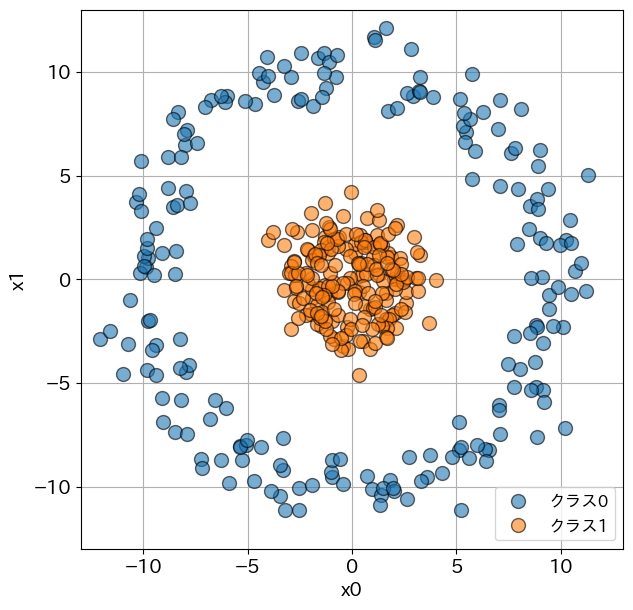

(-13, 13)

In [6]:
import pandas as pd
import numpy as np

df=pd.read_csv('data7.csv')
# リストに複数の列名（文字列）を格納し、
# 同時に2列をデータフレームから取得
x=df[['x0','x1']].to_numpy()
y=df['y'].to_numpy()
print('データ数:', len(x))
print('xの形状:', x.shape)
print('yの形状:', y.shape)

show_data2(x,y) # データ分布の可視化

# 実習7.2：教師データを訓練データとテストデータに分割する

訓練データ数: 280
テストデータ数: 120


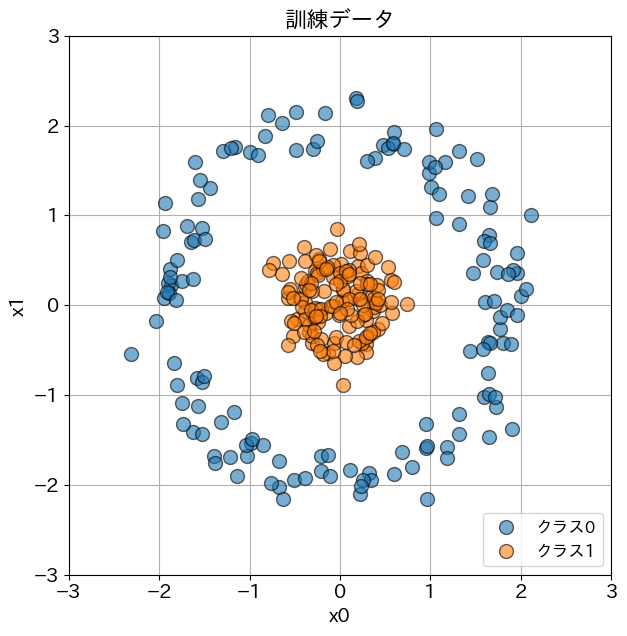

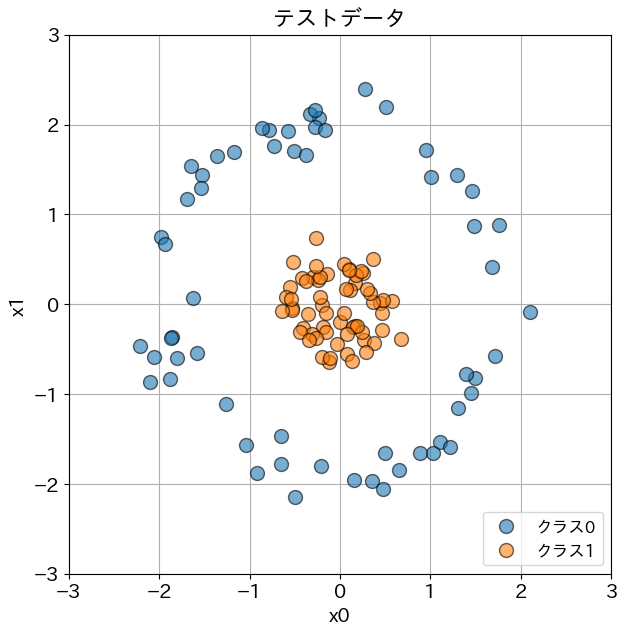

(-3, 3)

In [7]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,  # 分割するデータ1セット目
                                               y,  # 分割するデータ2セット目
                                               test_size=0.3, # テストデータの割合
                                               shuffle=True,
                                               random_state=0) # 乱数シード

print('訓練データ数:', len(x_train))
print('テストデータ数:', len(x_test))

m=np.mean(x_train,axis=0) # 行方向に平均を計算
s=np.std(x_train,axis=0) # 行方向に標準偏差を計算

# 訓練データの平均と標準偏差で訓練データを標準化
x_train=(x_train-m)/s

# 訓練データの平均と標準偏差でテストデータを標準化
x_test=(x_test-m)/s

# 訓練データの分布を可視化
show_data2(x_train,y_train,title='訓練データ')

# テストデータの分布を可視化
show_data2(x_test,y_test,title='テストデータ')

# 実習7.3：中間層をもつネットワークモデルの構築

In [8]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
    tensorflow.random.set_seed(0) # パラメータの初期値を生成する乱数シードを固定
    model=Sequential() # ネットワークの容れ物を作る

    # 中間層を全結合層として作り、モデルに追加
    model.add(Dense(input_dim=2,   # 1個の入力データの成分数
                    units=3,       # 中間層のニューロン数
                    activation='sigmoid', # 中間層の活性化関数
                    name='hidden')) # 中間層の名前

    # 出力層を全結合層として作り、モデルに追加
    # 最初の中間層より後の層では、input_dim引数は不要
    model.add(Dense(units=1, # 出力層のニューロン数
                    activation='sigmoid', # 出力層の活性化関数
                    name='output')) # 出力層の名前

    # 損失関数と最適化手法の設定
    model.compile(optimizer='SGD',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

################################################
# メイン
# 関数build_modelを呼び、モデルを構築するテスト
################################################
test_model=build_model()
test_model.summary() # モデルの要約情報を表示

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 3)                 9         
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


# 実習7.4：バッチ学習

In [9]:
# モデルを構築し、変数model1に代入
model1=build_model()

history1=model1.fit(x_train, # ネットワークへの入力データ
                    y_train, # 正解クラスラベル 
                    epochs=1500, # エポック数
                    batch_size=len(x_train), # バッチサイズ=訓練データ数
                    validation_data=(x_test,y_test)) # 学習過程の汎化能力検証用データ

Epoch 1/1500
1/1 [==============================] - 1s 1s/step - loss: 0.7762 - accuracy: 0.4964 - val_loss: 0.7545 - val_accuracy: 0.5083
Epoch 2/1500
1/1 [==============================] - 0s 40ms/step - loss: 0.7755 - accuracy: 0.4964 - val_loss: 0.7539 - val_accuracy: 0.5083
Epoch 3/1500
1/1 [==============================] - 0s 43ms/step - loss: 0.7749 - accuracy: 0.4964 - val_loss: 0.7533 - val_accuracy: 0.5083
Epoch 4/1500
1/1 [==============================] - 0s 44ms/step - loss: 0.7743 - accuracy: 0.4964 - val_loss: 0.7527 - val_accuracy: 0.5083
Epoch 5/1500
1/1 [==============================] - 0s 57ms/step - loss: 0.7736 - accuracy: 0.4964 - val_loss: 0.7522 - val_accuracy: 0.5083
Epoch 6/1500
1/1 [==============================] - 0s 38ms/step - loss: 0.7730 - accuracy: 0.4964 - val_loss: 0.7516 - val_accuracy: 0.5083
Epoch 7/1500
1/1 [==============================] - 0s 40ms/step - loss: 0.7724 - accuracy: 0.4964 - val_loss: 0.7511 - val_accuracy: 0.5083
Epoch 8/1500
1/

# 実習7.5：性能評価用関数の実装

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(x,y_true,model):
    """データの分布と決定境界の表示、混同行列・正解率・精度・再現率を計算する。
    Args:
        x (ndarray):2次元入力データ
        t_true (ndarray):入力データyの正解クラスラベル。1次元配列
        model (tensorflow.keras.model.*): ネットワークモデル
    """
    # データ分布と決定境界を表示
    show_contour2(x,y_true,model)
    # 入力データxに対して、クラス1である条件付き確率を計算
    y_pred=model.predict(x,verbose=0)
    # 予測結果 y_predの形状を2次元配列(N, 1)から1次元配列に変形
    y_pred=y_pred.flatten()
    # 確率が0.5以上の要素をクラスラベル1とする。
    y_pred=(y_pred>=0.5)*1
    
    cm=confusion_matrix(y_true,y_pred) # 混同行列計算
    accuracy=accuracy_score(y_true,y_pred) # 正解率計算
    precision=precision_score(y_true,y_pred,average=None) # 精度計算
    recall=recall_score(y_true,y_pred,average=None) # 再現率計算
    print(f'混同行列')
    print(cm)
    print('正解率:', accuracy)
    print('精度:', precision)
    print('再現率:', recall)

    # 混同行列の可視化
    plt.figure(figsize=(7,7))
    sns.heatmap(cm,annot=True,fmt='3d',square=True,cmap='hot')
    plt.show()

# 実習7.6：バッチ学習の履歴と汎化能力の推定

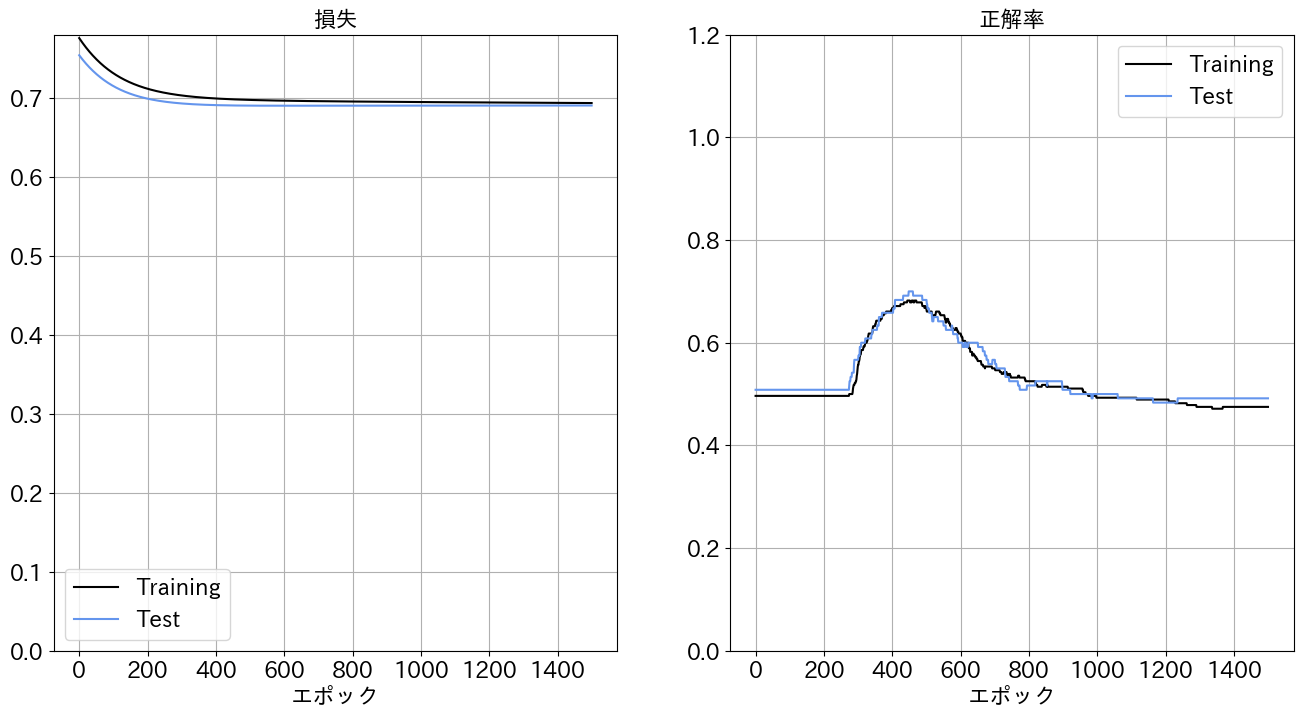

訓練データに対する分類性能


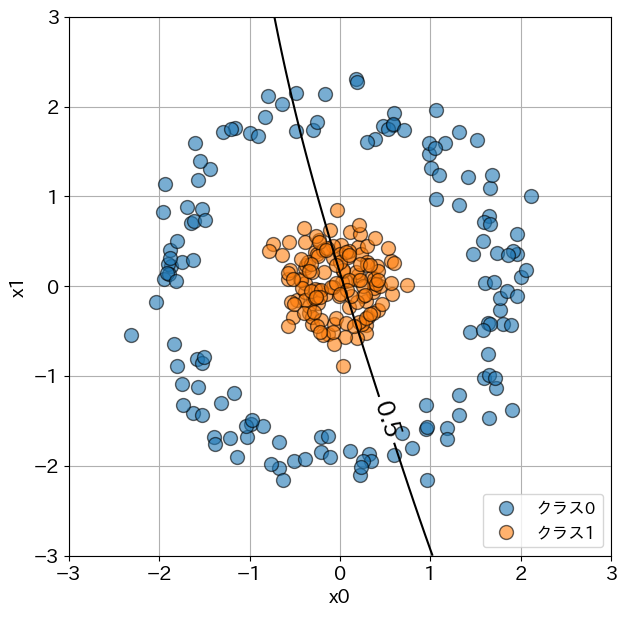

混同行列
[[71 70]
 [77 62]]
正解率: 0.475
精度: [0.47972973 0.46969697]
再現率: [0.5035461  0.44604317]


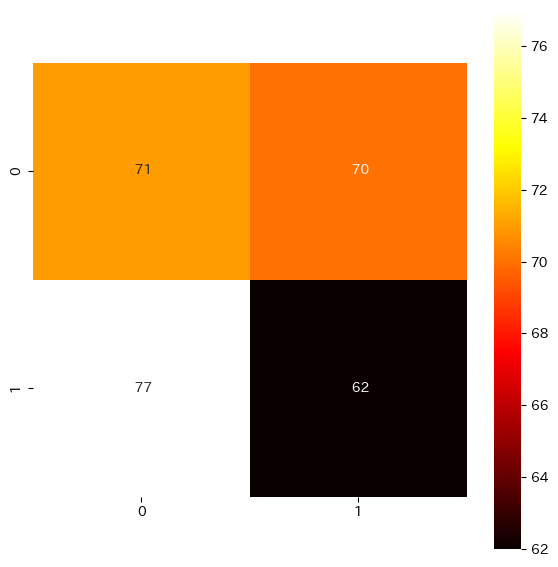

テストデータに対する分類性能


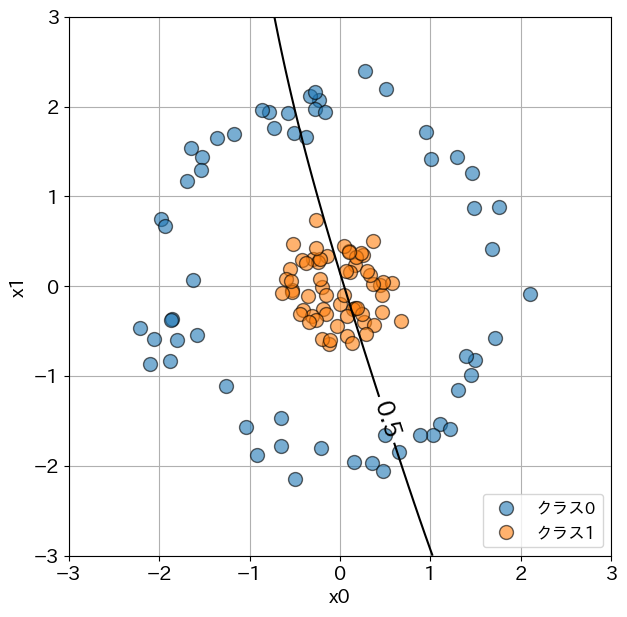

混同行列
[[33 26]
 [35 26]]
正解率: 0.49166666666666664
精度: [0.48529412 0.5       ]
再現率: [0.55932203 0.42622951]


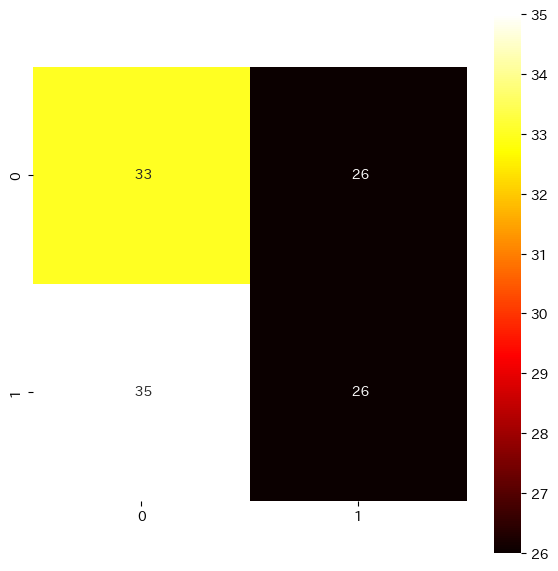

In [11]:
# 損失と正解率の履歴を表示する
show_history(history1)

# 訓練データに対する性能の確認
print('訓練データに対する分類性能')
evaluate(x_train,y_train,model1)

# テストデータを使う汎化能力の推定
print('テストデータに対する分類性能')
evaluate(x_test,y_test,model1)

# 実習7.7：オンライン学習

In [13]:
# モデルを構築し、変数model2に代入
model2=build_model()

history2=model2.fit(x_train,y_train,
                    epochs=1500,
                    batch_size=1, # オンライン学習
                    shuffle=True,
                    validation_data=(x_test,y_test))

Epoch 1/1500
280/280 [==============================] - 3s 6ms/step - loss: 0.7138 - accuracy: 0.5036 - val_loss: 0.7010 - val_accuracy: 0.4917
Epoch 2/1500
280/280 [==============================] - 1s 5ms/step - loss: 0.6952 - accuracy: 0.4929 - val_loss: 0.6946 - val_accuracy: 0.4167
Epoch 3/1500
280/280 [==============================] - 1s 4ms/step - loss: 0.6942 - accuracy: 0.4607 - val_loss: 0.6943 - val_accuracy: 0.2917
Epoch 4/1500
280/280 [==============================] - 1s 4ms/step - loss: 0.6930 - accuracy: 0.4643 - val_loss: 0.6951 - val_accuracy: 0.4917
Epoch 5/1500
280/280 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.4750 - val_loss: 0.6940 - val_accuracy: 0.6833
Epoch 6/1500
280/280 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.5286 - val_loss: 0.6944 - val_accuracy: 0.3000
Epoch 7/1500
280/280 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.4107 - val_loss: 0.6941 - val_accuracy:

# 実習7.8：オンライン学習の履歴と汎化能力の推定

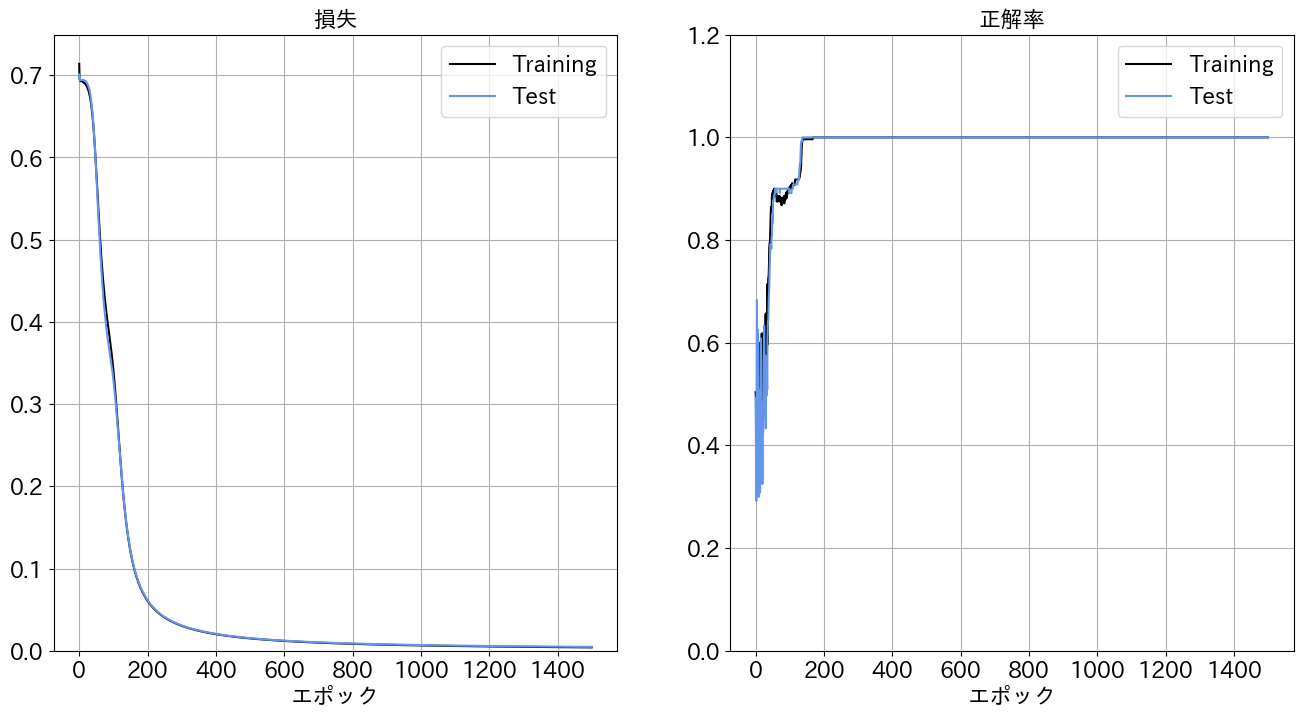

訓練データに対する分類性能


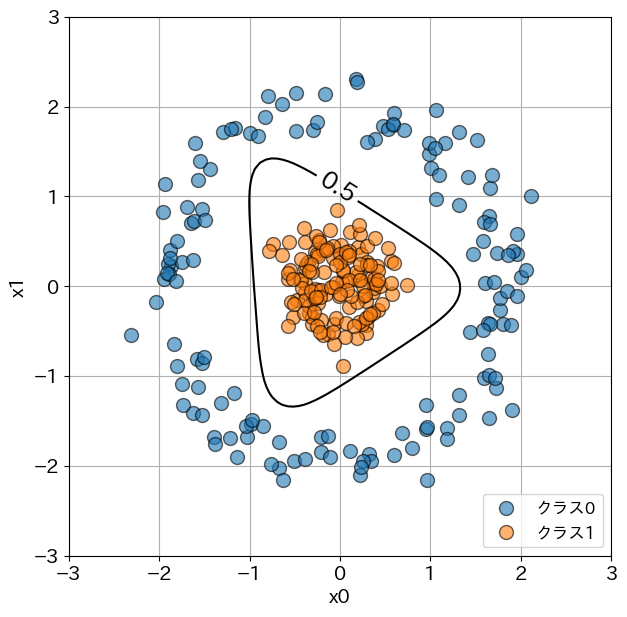

混同行列
[[141   0]
 [  0 139]]
正解率: 1.0
精度: [1. 1.]
再現率: [1. 1.]


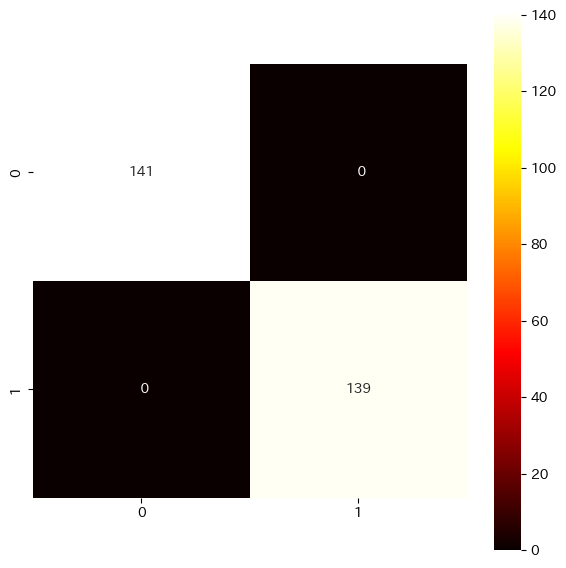

テストデータに対する分類性能


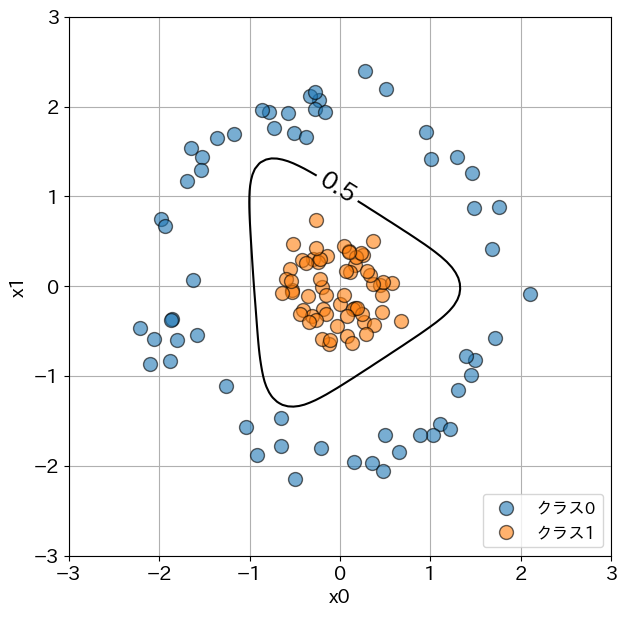

混同行列
[[59  0]
 [ 0 61]]
正解率: 1.0
精度: [1. 1.]
再現率: [1. 1.]


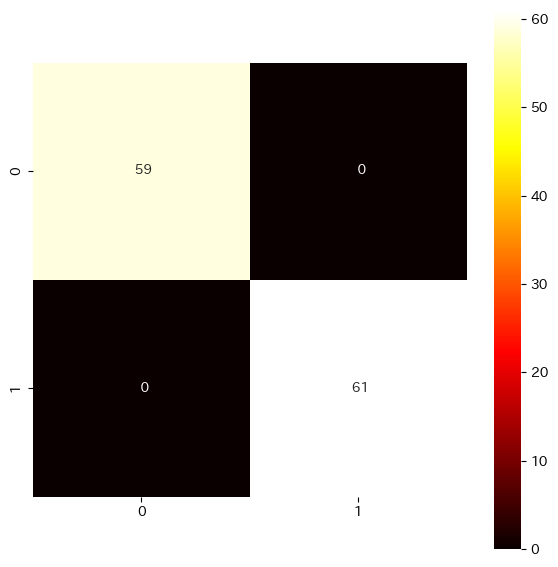

In [14]:
# 損失と正解率の履歴を表示する
show_history(history2)

# 訓練データに対する性能の確認
print('訓練データに対する分類性能')
evaluate(x_train,y_train,model2)

# テストデータを使う汎化能力の推定
print('テストデータに対する分類性能')
evaluate(x_test,y_test,model2)

# 実習7.9：ミニバッチ学習

In [15]:
# モデルを構築し、変数model3に代入
model3=build_model()

history3=model3.fit(x_train,y_train,
                    epochs=1500,
                    batch_size=10,
                    validation_data=(x_test,y_test))

Epoch 1/1500
28/28 [==============================] - 1s 8ms/step - loss: 0.7933 - accuracy: 0.4964 - val_loss: 0.7761 - val_accuracy: 0.5083
Epoch 2/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.7724 - accuracy: 0.4964 - val_loss: 0.7588 - val_accuracy: 0.5083
Epoch 3/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.7557 - accuracy: 0.4964 - val_loss: 0.7450 - val_accuracy: 0.5083
Epoch 4/1500
28/28 [==============================] - 0s 6ms/step - loss: 0.7422 - accuracy: 0.4964 - val_loss: 0.7341 - val_accuracy: 0.5083
Epoch 5/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.7316 - accuracy: 0.4964 - val_loss: 0.7258 - val_accuracy: 0.5083
Epoch 6/1500
28/28 [==============================] - 0s 6ms/step - loss: 0.7233 - accuracy: 0.4964 - val_loss: 0.7191 - val_accuracy: 0.5083
Epoch 7/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.7167 - accuracy: 0.4964 - val_loss: 0.7140 - val_accuracy: 0.5083
Epoch 

# 実習7.10：ミニバッチ学習の履歴と汎化能力の推定

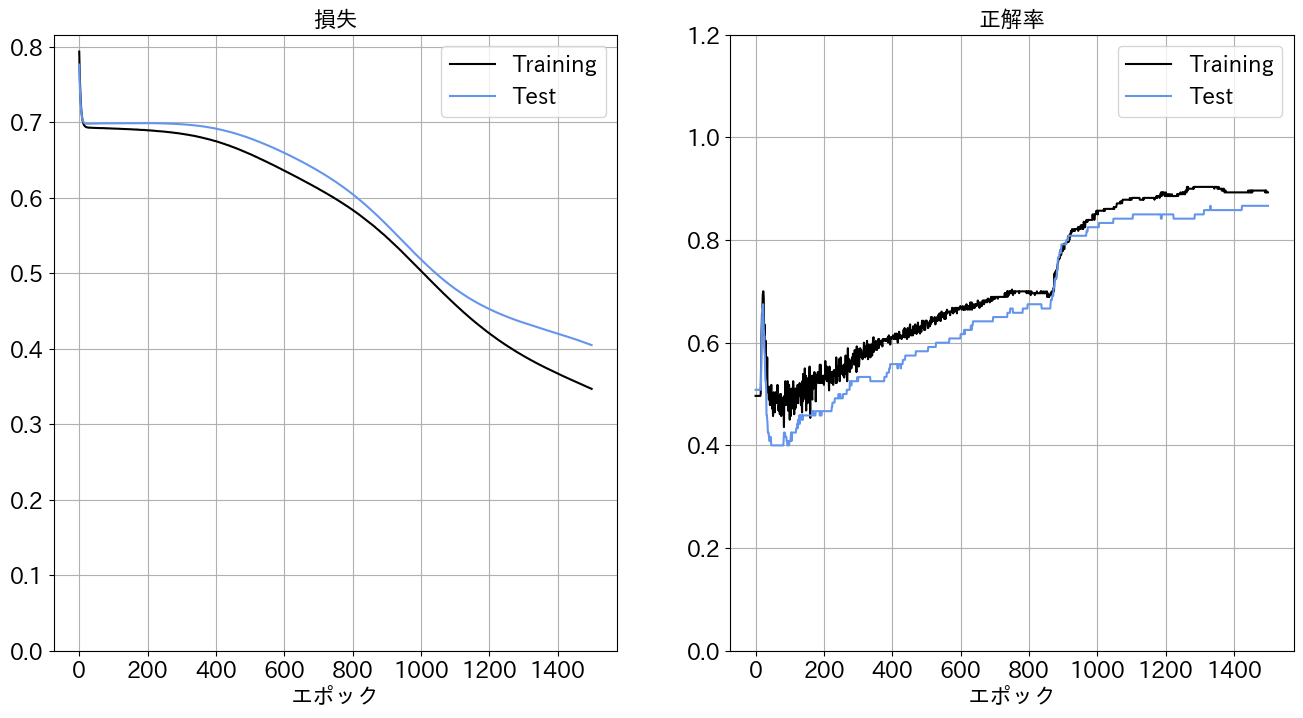

訓練データに対する分類性能


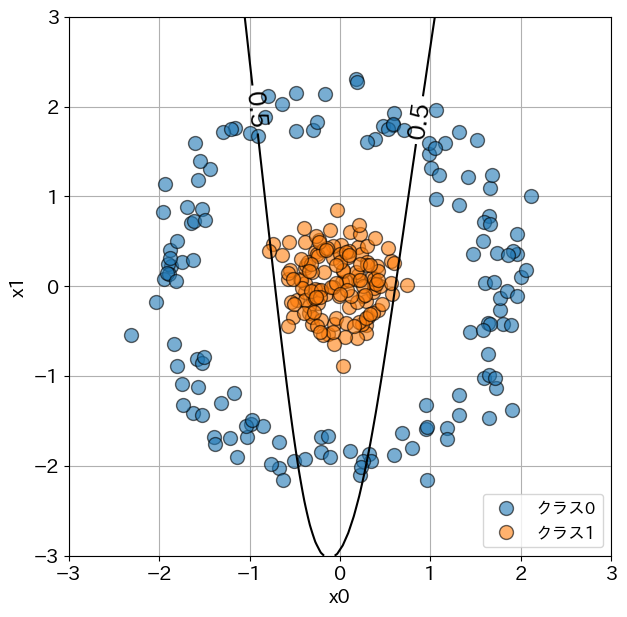

混同行列
[[113  28]
 [  2 137]]
正解率: 0.8928571428571429
精度: [0.9826087  0.83030303]
再現率: [0.80141844 0.98561151]


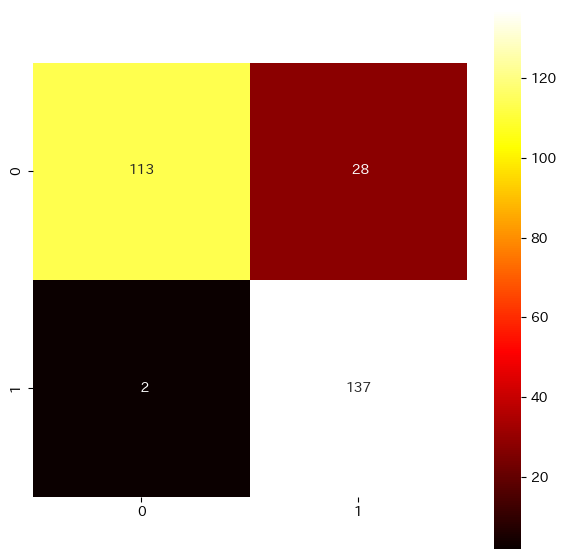

テストデータに対する分類性能


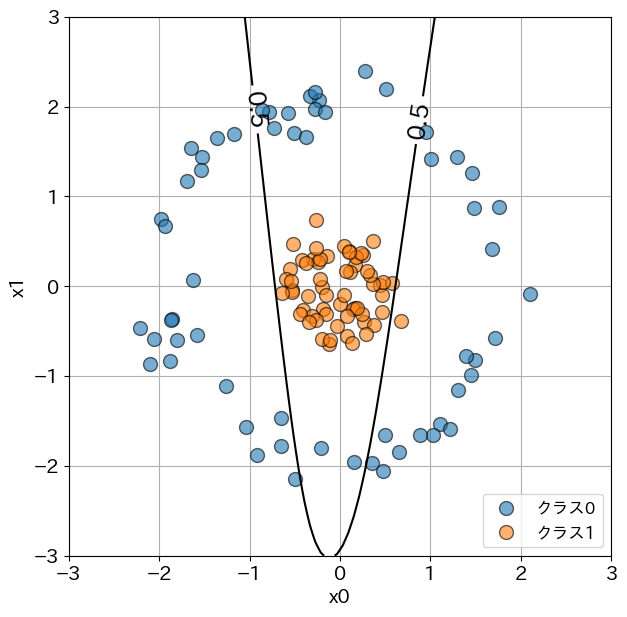

混同行列
[[44 15]
 [ 1 60]]
正解率: 0.8666666666666667
精度: [0.97777778 0.8       ]
再現率: [0.74576271 0.98360656]


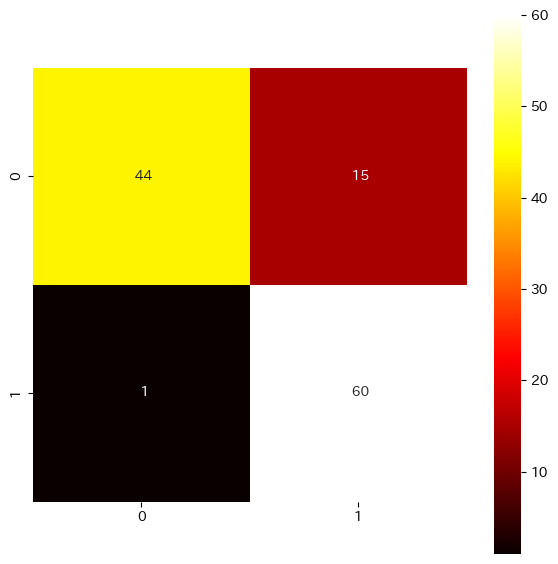

In [16]:
# 損失と正解率の履歴を表示する
show_history(history3)

# 訓練データに対する性能の確認
print('訓練データに対する分類性能')
evaluate(x_train,y_train,model3)

# テストデータに対する汎化能力の推定
print('テストデータに対する分類性能')
evaluate(x_test,y_test,model3)